# Swift Pipeline
This notebook serves as record keeping and a tutorial for using the python scripts to automatically process data from the Neil Gehrels Swift Observatory (Swift).

In order to use these tools you will need a working installation of *HEASoft* ([see here for installing using using *conda*](https://heasarc.gsfc.nasa.gov/docs/software/conda.html)) as well as the [Swift Calibration Files](https://swift.gsfc.nasa.gov/caldb/).

The Calibration Database is also necessary ([see here for installing CALDB](https://heasarc.gsfc.nasa.gov/docs/heasarc/caldb/caldb_install.html)). This code has not yet been tested using a remote CALDB installation.

This will specifically follow the example of analysis of Mrk 501 in [this video](https://www.youtube.com/watch?v=ztOg7_rovAw), and draws from [The SWIFT XRT Data Reduction Guide](https://swift.gsfc.nasa.gov/analysis/xrt_swguide_v1_2.pdf)

In [1]:
%load_ext autoreload
%autoreload 2
%aimport -swifttools.ukssdc.data #ignore swifttools
#Automatically reloads import, allowing changes to be made and used every time

## Download the data

The downloading of the Swift data can be done online (https://www.swift.ac.uk/swift_portal/) or it can be conveniently handled by the the [*swifttools*](https://www.swift.ac.uk/API/) package, which allows for the automatic downloading of data according to the observation ID.

The followng cell imports the package and download the data into a subfolder, according to the observation ID. It then stores it in the path specified by the variable *data_download_path*.

Please note that the full path, rather than the relative path, must be used for the following functions.

In [2]:
data_download_path='/home/user/Documents/swift_pipeline/data/'

In [3]:
import swifttools.ukssdc.data
try: 
    swifttools.ukssdc.data.downloadObsData(['00011184023'],destDir=data_download_path,silent=False)
except:
    print("Folder already exists")

Folder already exists


---
## Sub folders:
####  */auxil/* - Auxilary files
 - sw[ObsId].pat.fits.gz - Primary Attitude FITS 
 - sw[ObsId].sat.fits.gz - Secondary Attitude FITS 
 - sw[ObsId].sao.fits.gz - Orbit ephemeris FITS 



####  */bat/* - Burst Alert Telescope files


####  */uvot/* - Ultra-Violet/Optical Telescope files


####  */xrt/* - X-Ray Telescope files
---
## FITS File names
The naming format for the Swift XRT  science files is as follows:

- *sw<u>**00011184023**</u>xwtw2po_cl.evt* - The observation ID
- *sw00011184023<u>**x**</u>wtw2po_cl.evt* - The instrument used (XRT)
- *sw00011184023x<u>**wt**</u>w2po_cl.evt* - The mode used. Possible values are:
    - *pc* - Photon counting
    - *wt* - Windowed
    - *pu* - Piled Up
    - *lr* - Low rate
    - *im* - Imaged
- *sw00011184023xwt<u>**w2**</u>po_cl.evt* - The window setting in wt/pc mode. See [The SWIFT XRT Data Reduction Guide](https://swift.gsfc.nasa.gov/analysis/xrt_swguide_v1_2.pdf) for more details.
- *sw00011184023xwtw2<u>**po**</u>_cl.evt* - Mode of the satellite when data event data was recorded.
     - *po* - pointing mode
     - *sl* - slewing
     - *st* - settling
- *sw00011184023xwtw2po_<u>**cl**</u>.evt* - File data level.
     - *uf* - Level 1 (events)
     - *ufre* - Level 1a (events)
     - *cl* - Level 2 (events)
     - *rw* - Level 1 (image)
     - *sk* - Level 2 (image)

## XRT Data processing
To use the *HEASoft* tools, you must first run the script that initialises *HEASoft* in the terminal.

*CALDB* must also be initialised in order to automatically use the response functions for Swift.

If these cannot be found the importing of *swiftpipeline* will throw an error.

In [4]:
import swiftpipeline as sp

### Cleaning events with *xrtpipeline*
In order to use the data from the XRT, it must first be cleaned using the  [*xrtpipeline*](https://heasarc.gsfc.nasa.gov/lheasoft/help/xrtpipeline.html). If the source coordinates are not provided, they will be read directly from the *pat* FITS file.

In [5]:
raw_data_folder=data_download_path+'00011184023/'
output_folder='/home/user/Documents/swift_pipeline/data/00011184023_auto/'

In [6]:
sp.run_xrtpipeline(raw_data_folder=raw_data_folder,output_folder=output_folder)

---
### Barycentric corrections
Next a barycentric correction ([barycorr](https://heasarc.gsfc.nasa.gov/lheasoft/help/barycorr.html)) is run to correct for GR effects on the satellite. Not particularly important for AGNs, but seems essential for GRBs.

The PAT and SAO files are copied from the original data folder to the same folder as the *xrtpipeline* output folder. The cleaned events (*po_cl*), primary attitude (*pat*), and secondary attitude (*sao*) files are corrected. All corrected files are given the suffix of *"_barycentric_correction"*.

In [7]:
sp.run_barycentric_correction(data_folder=raw_data_folder,xrtpipeline_output_folder=output_folder)

---
### Extracting  high level product data products from a cleaned event file with *xrtproducts*
In order to convert the cleaned event file to high-level data products, *xrtproducts* is used. 

The background can automatically generated as an annullus around the observing region **BUT** must be carefully checked, as it does not exclude other possible sources. The parameters *gap_ratio* and *area_ratio* can be specified. *gap_ratio* refers to the ratio between the the inner radius of the annulus and the radius of the source region. *area_ratio* refers to the ratio between the total area of the the background region and the source region. \
If a separate background file is specified through the *background_region_file* parameter then that background region file will be used.

In [8]:
sp.run_xrtproducts(raw_data_folder=raw_data_folder,data_folder=output_folder,output_folder=output_folder)

To check that everything has been processed successfully you can make a diagnostic plot of the observartion and the processed data. 

- SKY SPACE: The data projected onto the sky,as well as the regions used to process the source and background data.
- COUNTS: The counts recorded in each channel. The background should always be roughly less than or equal to the source.
- TELESCOPE POINTING: The field-of-view of the telescope duting pointing, as well as the coordinated of the object being observed. The path of the centre of the telescope pointing is also plotted, and should always seem to form a dot, otherwise there may be an issue with the slewing.
- DETECTOR SPACE: The raw pixel data from the detector, before and after cleaning.
- COUNT RATE: The count rate over the duration of the observation. If the source is not transient then this 'lightcurve' should remain relatively constant.

/home/user/Documents/swift_pipeline/swiftpipeline.py:807: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  current_ax.legend(loc='upper right',fontsize=fontsize_legend)


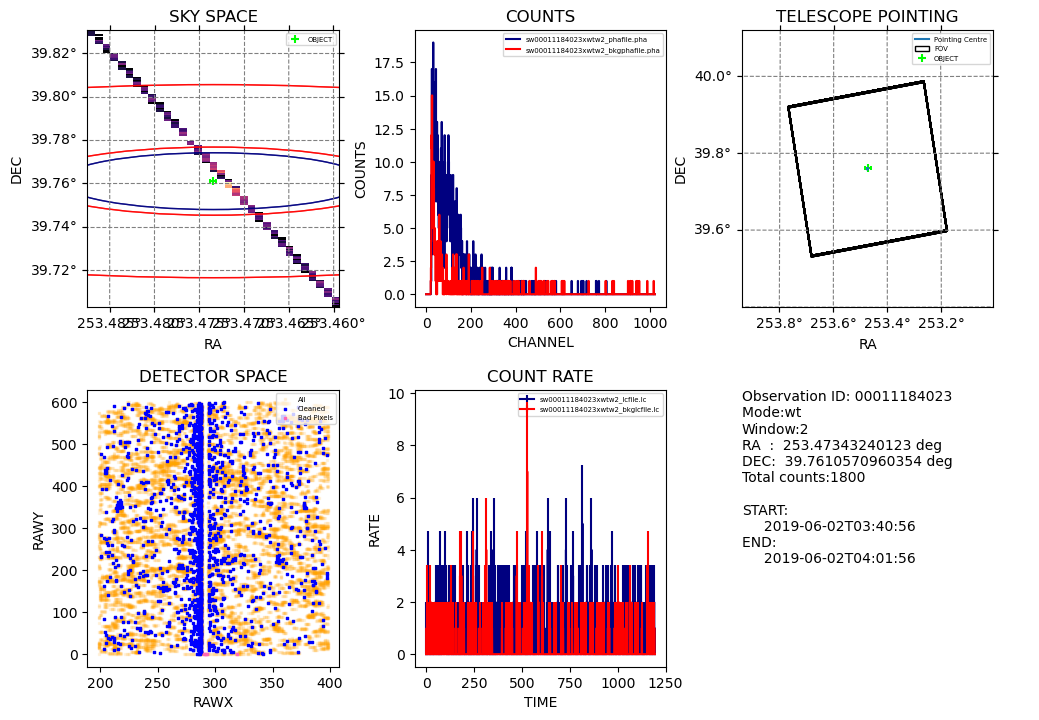

In [9]:
sp.generate_diagnostic_plot(data_folder=raw_data_folder,mode='wt',window='2',pha_folder=output_folder)

---
### Running all steps at once

All of the aforementioned steps have been bundled into a single function, *swiftxrtpipeline*. The following demonstrates this using a different observation, one with the satellite in photon-counting mode, rather than window-timing mode.

In [10]:
data_download_path='/home/user/Documents/swift_pipeline/data/'

try: 
    swifttools.ukssdc.data.downloadObsData(['00030795038'],destDir=data_download_path,silent=False)
except:
    print("Folder already exists")

Folder already exists


In [11]:
raw_data_folder=data_download_path+'00030795038/'
output_folder='/home/user/Documents/swift_pipeline/data/00030795038_auto/'

sp.swiftxrtpipeline(raw_data_folder=raw_data_folder,output_folder=output_folder)

xrtpipeline DONE!
barycentric corrections DONE!
xrtproducts DONE!


/home/user/Documents/swift_pipeline/swiftpipeline.py:807: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  current_ax.legend(loc='upper right',fontsize=fontsize_legend)


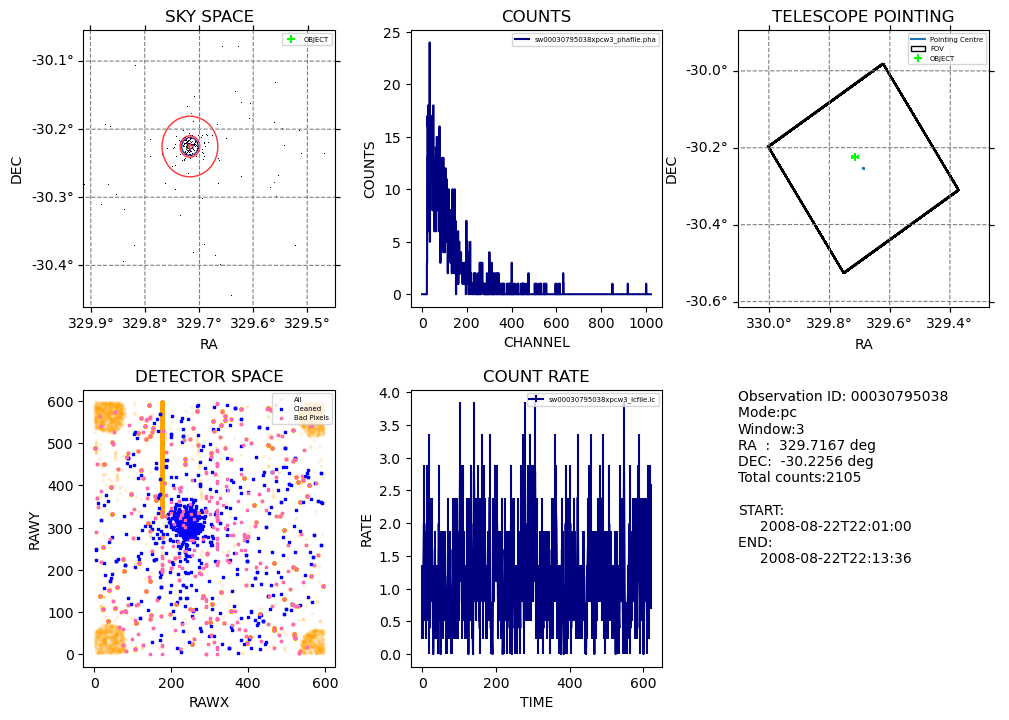

In [12]:
sp.generate_diagnostic_plot(data_folder=raw_data_folder,mode='pc',window='3',pha_folder=output_folder)